In [1]:
!wget 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz'
!gunzip cc.it.300.vec.gz

! pip install simplemma

--2023-06-25 14:41:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.42, 13.224.2.88, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272825284 (1.2G) [binary/octet-stream]
Saving to: ‘cc.it.300.vec.gz’

cc.it.300.vec.gz    100%[===================>]   1.18G  33.1MB/s    in 31s     

2023-06-25 14:41:44 (39.3 MB/s) - ‘cc.it.300.vec.gz’ saved [1272825284/1272825284]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 MB 9.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import string
import spacy
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn.model_selection import KFold
import nltk
import re
from nltk.corpus import stopwords
from snowballstemmer import stemmer

In [3]:
# used in Colab to use GPU and avoid errors

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
from nltk.stem.snowball import SnowballStemmer
import simplemma
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stemmer = SnowballStemmer('italian')
punctuations = string.punctuation
stop_words = set(stopwords.words('italian'))
parser = Italian()


def text_cleaning(text):
  text = text.lower()
  text = re.sub(r"URL|url", '', text)
  text = re.sub(r'@\w+\s*', '', text)
  text = re.sub(r'\b\w*\d\w*\b', '', text)
  text = re.sub(r"\.{2,4}", '', text)

  text = word_tokenize(text)
  text = [simplemma.lemmatize(token, lang='it') for token in text]
  text = [stemmer.stem(token) for token in text]
  text = [token for token in text if token not in stop_words and token not in punctuations ]

  # Join the stemmed tokens back into a single string
  cleaned_text = ' '.join(text)

  return cleaned_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        f.readline # skip first line that contains word space info
        for line in f:
            word, *vector = line.split()
            if word in word_index: # load only word embeddings into the vocabulary
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix


In [6]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot
from numpy import where
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np


d = pd.read_csv('./trainingset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
d = d.drop(0)

task_label = "hs"


X_tr = d['text'] # the features
y_train = d[task_label] # the labels
print(d.info)


t = pd.read_csv('./testset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
#t = t.drop(0)
X_te = t['text'] # the features
y_test = t[task_label] # the labels

n = pd.read_csv('./testset_news.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
X_te_news = n['text'] # the features
y_test_news = n[task_label] # the labels


X_tr = X_tr.apply(text_cleaning)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_tr)

X_train = tokenizer.texts_to_sequences(X_tr)
X_test = tokenizer.texts_to_sequences(X_te)
X_test_news = tokenizer.texts_to_sequences(X_te_news)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 128

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_test_news = pad_sequences(X_test_news, padding='post', maxlen=maxlen)

# Undersampling
undersample = NearMiss(version=2, n_neighbors=3)
X_undersampled, y_undersampled = undersample.fit_resample(X_train, y_train)

# Oversampling
sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())


y_train = to_categorical(y_train, dtype ="int")
y_undersampled = to_categorical(y_undersampled, dtype ="int")
y_smote = to_categorical(y_smote, dtype ="int")


# Train - Validation Set split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train_und, X_val_und, y_train_und, y_val_und = train_test_split(X_undersampled, y_undersampled, test_size=0.2)
X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(X_smote, y_smote, test_size=0.2)



<bound method DataFrame.info of         id                                               text hs st
1     2066  È terrorismo anche questo, per mettere in uno ...  0  0
2     2045  @user @user infatti finché ci hanno guadagnato...  0  0
3       61  Corriere: Tangenti, Mafia Capitale dimenticata...  0  0
4     1259  @user ad uno ad uno, perché quando i migranti ...  0  0
5      949  Il divertimento del giorno? Trovare i patrioti...  0  0
...    ...                                                ... .. ..
6833  9340  Gli stati nazionali devono essere pronti a rin...  0  0
6834  9121  Il ministro dell'interno della Germania #Horst...  0  0
6835  8549  #Salvini: In Italia troppi si sono montati la ...  0  0
6836  9240  @user @user Chi giubila in buona fede non ha c...  0  0
6837  8000  I giovani cristiani in #Etiopia sono indotti d...  0  1

[6837 rows x 4 columns]>


In [7]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('./cc.it.300.vec', tokenizer.word_index, embedding_dim)


nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Vocabulary coverage: ',nonzero_elements / vocab_size)

Vocabulary coverage:  0.4550300363820966


In [8]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function used to evaluate the results of the model

def evaluating_results(X_test, y_test, classifier):
    pred = classifier.predict(X_test)
    predicted = np.argmax(pred, axis=-1)

    y_test = [int(x) for x in y_test]
    predicted = predicted.astype(int)

    acc = metrics.accuracy_score(y_test, predicted)
    print("Accuracy:", acc)
    precision = metrics.precision_score(y_test, predicted, average='macro')
    recall = metrics.recall_score(y_test, predicted, average='macro')
    fm = metrics.f1_score(y_test, predicted, average='macro')
    print("P={0}, R={1}, F1={2}".format(precision, recall, fm))
    print("======================================================")
    print(metrics.classification_report(y_test, predicted, digits=4))

    cm = confusion_matrix(y_test, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [10]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Vocabulary coverage: ',nonzero_elements / vocab_size)

Vocabulary coverage:  0.4550300363820966


In [11]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelBinarizer

maxlen= 128

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True))
model.add(layers.Conv1D(512, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          3545700   
                                                                 
 conv1d (Conv1D)             (None, 124, 512)          768512    
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 4,577,894
Trainable params: 4,577,894
Non-trainable params: 0
______________________________________________

**Training with the original dataset**

In [12]:
import keras
from keras import backend

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

keras.backend.clear_session()

model.fit(X_train,  y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=64)

Epoch 1/50
86/86 [==============================] - 29s 206ms/step - loss: 0.5681 - accuracy: 0.6873 - val_loss: 0.4722 - val_accuracy: 0.7558
Epoch 2/50
86/86 [==============================] - 7s 81ms/step - loss: 0.2902 - accuracy: 0.8780 - val_loss: 0.5363 - val_accuracy: 0.7493
Epoch 3/50
86/86 [==============================] - 5s 56ms/step - loss: 0.0780 - accuracy: 0.9782 - val_loss: 0.7788 - val_accuracy: 0.7354
Epoch 4/50
86/86 [==============================] - 3s 39ms/step - loss: 0.0288 - accuracy: 0.9938 - val_loss: 0.9161 - val_accuracy: 0.7398
Epoch 5/50
86/86 [==============================] - 4s 44ms/step - loss: 0.0147 - accuracy: 0.9978 - val_loss: 0.9274 - val_accuracy: 0.7580
Epoch 6/50
86/86 [==============================] - 3s 41ms/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.9899 - val_accuracy: 0.7551


40/40 [==============================] - 0s 4ms/step
Accuracy: 0.6120348376880443
P=0.6133612792182555, R=0.6126618376632171, F1=0.6116255660538391
              precision    recall  f1-score   support

           0     0.6299    0.5710    0.5990       641
           1     0.5968    0.6543    0.6242       622

    accuracy                         0.6120      1263
   macro avg     0.6134    0.6127    0.6116      1263
weighted avg     0.6136    0.6120    0.6114      1263



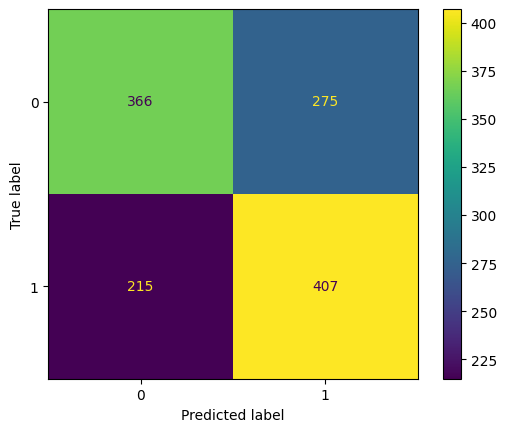

In [13]:
evaluating_results(X_test, y_test, model)

16/16 [==============================] - 0s 6ms/step
Accuracy: 0.612
P=0.5199229958955359, R=0.5094996449540172, F1=0.4741521380865643
              precision    recall  f1-score   support

           0     0.6430    0.8809    0.7434       319
           1     0.3968    0.1381    0.2049       181

    accuracy                         0.6120       500
   macro avg     0.5199    0.5095    0.4742       500
weighted avg     0.5539    0.6120    0.5485       500



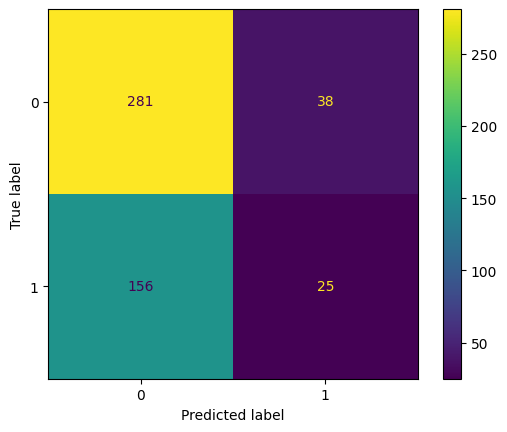

In [14]:
evaluating_results(X_test_news, y_test_news, model)

**Training with the undersampled dataset**

In [15]:
model.fit(X_train_und, y_train_und,
                      epochs=50,
                      verbose=True,
                      validation_data=(X_val_und, y_val_und),
                      callbacks=[early_stopping],
                      batch_size=64)


Epoch 1/50
70/70 [==============================] - 3s 49ms/step - loss: 0.3535 - accuracy: 0.8427 - val_loss: 0.3995 - val_accuracy: 0.8284
Epoch 2/50
70/70 [==============================] - 2s 33ms/step - loss: 0.0994 - accuracy: 0.9668 - val_loss: 0.4763 - val_accuracy: 0.8211
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0274 - accuracy: 0.9937 - val_loss: 0.6020 - val_accuracy: 0.8040
Epoch 4/50
70/70 [==============================] - 2s 28ms/step - loss: 0.0115 - accuracy: 0.9984 - val_loss: 0.6858 - val_accuracy: 0.7995
Epoch 5/50
70/70 [==============================] - 1s 21ms/step - loss: 0.0099 - accuracy: 0.9989 - val_loss: 0.6963 - val_accuracy: 0.8049
Epoch 6/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 0.7022 - val_accuracy: 0.8040


40/40 [==============================] - 0s 2ms/step
Accuracy: 0.5716547901821061
P=0.572209653092006, R=0.5720462902117371, F1=0.5715247838914895
              precision    recall  f1-score   support

           0     0.5833    0.5460    0.5641       641
           1     0.5611    0.5981    0.5790       622

    accuracy                         0.5717      1263
   macro avg     0.5722    0.5720    0.5715      1263
weighted avg     0.5724    0.5717    0.5714      1263



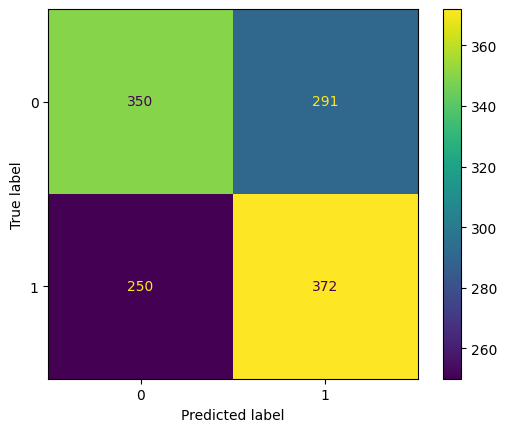

In [16]:
evaluating_results(X_test, y_test, model)

16/16 [==============================] - 0s 4ms/step
Accuracy: 0.662
P=0.6244282744282744, R=0.6036561076568697, F1=0.605654310501729
              precision    recall  f1-score   support

           0     0.7027    0.8150    0.7547       319
           1     0.5462    0.3923    0.4566       181

    accuracy                         0.6620       500
   macro avg     0.6244    0.6037    0.6057       500
weighted avg     0.6460    0.6620    0.6468       500



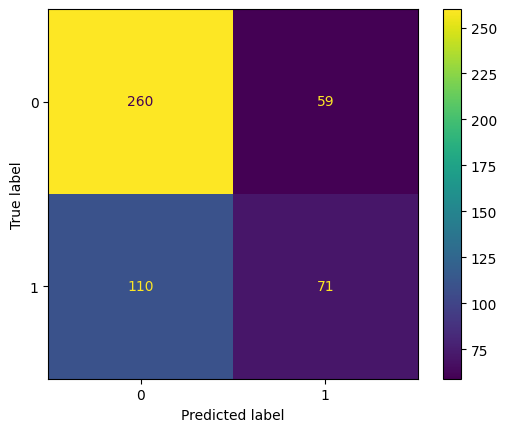

In [17]:
evaluating_results(X_test_news, y_test_news, model)

**Training with the oversampled dataset**

In [18]:
model.fit(X_train_sm, y_train_sm,
                      epochs=50,
                      verbose=True,
                      validation_data=(X_val_sm, y_val_sm),
                      callbacks=[early_stopping],
                      batch_size=64)


Epoch 1/50
102/102 [==============================] - 3s 32ms/step - loss: 0.3333 - accuracy: 0.8560 - val_loss: 0.3307 - val_accuracy: 0.8607
Epoch 2/50
102/102 [==============================] - 3s 26ms/step - loss: 0.0636 - accuracy: 0.9794 - val_loss: 0.4200 - val_accuracy: 0.8557
Epoch 3/50
102/102 [==============================] - 2s 21ms/step - loss: 0.0238 - accuracy: 0.9945 - val_loss: 0.4677 - val_accuracy: 0.8521
Epoch 4/50
102/102 [==============================] - 3s 25ms/step - loss: 0.0144 - accuracy: 0.9983 - val_loss: 0.4607 - val_accuracy: 0.8459
Epoch 5/50
102/102 [==============================] - 2s 19ms/step - loss: 0.0126 - accuracy: 0.9986 - val_loss: 0.4546 - val_accuracy: 0.8557
Epoch 6/50
102/102 [==============================] - 3s 26ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.4726 - val_accuracy: 0.8551


40/40 [==============================] - 0s 2ms/step
Accuracy: 0.5779889152810768
P=0.5808897149674066, R=0.5761897356923216, F1=0.5709297767579712
              precision    recall  f1-score   support

           0     0.5689    0.6958    0.6260       641
           1     0.5929    0.4566    0.5159       622

    accuracy                         0.5780      1263
   macro avg     0.5809    0.5762    0.5709      1263
weighted avg     0.5807    0.5780    0.5718      1263



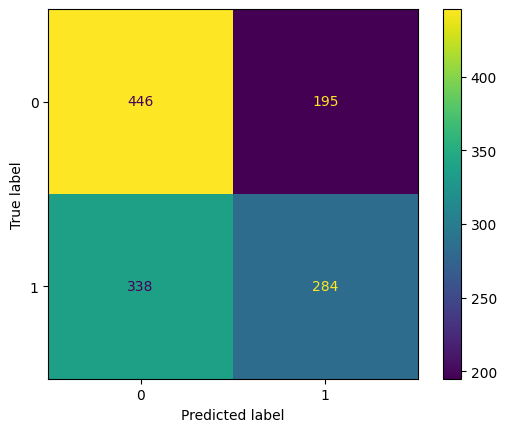

In [19]:
evaluating_results(X_test, y_test, model)

16/16 [==============================] - 0s 2ms/step
Accuracy: 0.69
P=0.6759386446886446, R=0.606479156202913, F1=0.6021049929405724
              precision    recall  f1-score   support

           0     0.6971    0.9091    0.7891       319
           1     0.6548    0.3039    0.4151       181

    accuracy                         0.6900       500
   macro avg     0.6759    0.6065    0.6021       500
weighted avg     0.6818    0.6900    0.6537       500



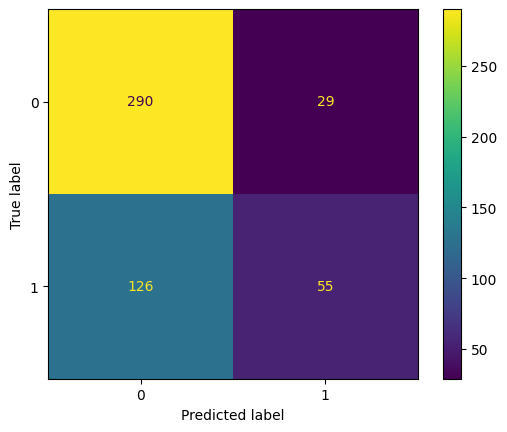

In [20]:
evaluating_results(X_test_news, y_test_news, model)